# Removing the Kenyon cells

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from giskard.plot import merge_axes
from myst_nb import glue as default_glue
from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import savefig
from pkg.plot import networkplot_simple, plot_density, plot_pvalues, set_theme
from pkg.stats import erdos_renyi_test, stochastic_block_test
from pkg.utils import get_toy_palette, sample_toy_networks


DISPLAY_FIGS = True

FILENAME = "kc_minus"


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, pad_inches=0, bbox_inches="tight", **kwargs)

    glue(name, fig, prefix="fig")

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, prefix=None):
    savename = f"{FILENAME}-{name}"
    if prefix is not None:
        savename = prefix + ":" + savename
    default_glue(savename, var, display=False)

In [2]:
t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()
neutral_color = sns.color_palette("Set2")[2]

GROUP_KEY = "simple_group"

left_adj, left_nodes = load_unmatched(side="left")
right_adj, right_nodes = load_unmatched(side="right")

# Remove kenyon cells
left_nodes["inds"] = range(len(left_nodes))
sub_left_nodes = left_nodes[left_nodes[GROUP_KEY] != "KCs"]
sub_left_inds = sub_left_nodes["inds"].values
right_nodes["inds"] = range(len(right_nodes))
sub_right_nodes = right_nodes[right_nodes[GROUP_KEY] != "KCs"]
sub_right_inds = sub_right_nodes["inds"].values

sub_left_adj = left_adj[np.ix_(sub_left_inds, sub_left_inds)]
sub_right_adj = right_adj[np.ix_(sub_right_inds, sub_right_inds)]
sub_left_labels = sub_left_nodes[GROUP_KEY]
sub_right_labels = sub_right_nodes[GROUP_KEY]

## Methods


A1, A2, node_data = sample_toy_networks()
palette = get_toy_palette()

fig, axs = plt.subplots(2, 2, figsize=(7, 6), gridspec_kw=dict(width_ratios=[1, 1.5]))

ax = axs[0, 0]
networkplot_simple(A1, node_data, palette=palette, ax=ax, group=True)
x, y = node_data[node_data["labels"] == 1][["x", "y"]].mean()
ax.text(x, y, "X", color="darkred", fontsize=80, va="center", ha="center")
ax.set(title="Remove Kenyon cells")
ax.set_ylabel(
    "Left",
    color=network_palette["Left"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

ax = axs[1, 0]
networkplot_simple(A2, node_data, palette=palette, ax=ax, group=True)
x, y = node_data[node_data["labels"] == 1][["x", "y"]].mean()
ax.text(x, y, "X", color="darkred", fontsize=80, va="center", ha="center")
ax.set_ylabel(
    "Right",
    color=network_palette["Right"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

from pkg.plot import draw_hypothesis_box

ax = merge_axes(fig, axs, rows=None, cols=1)
ax.axis("off")
ax.set(xlim=(0, 1), ylim=(0, 1))


kwargs = dict(yskip=0.07, ax=ax, title=True)
draw_hypothesis_box("er", 0.15, 0.8, **kwargs)
draw_hypothesis_box("sbm", 0.15, 0.5, **kwargs)
draw_hypothesis_box("dasbm", 0.15, 0.2, **kwargs)


ax.set_title("Re-run all tests")
plt.tight_layout()

gluefig("kc_minus_methods", fig)

## ER test

6.949928675622712e-27


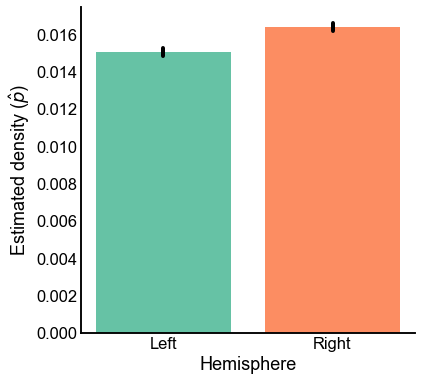

In [3]:

stat, pvalue, misc = erdos_renyi_test(sub_left_adj, sub_right_adj)
print(pvalue)
glue("er_pvalue", pvalue)

fig, ax = plot_density(misc, palette=network_palette)
gluefig("densities", fig)

## SBM test

0.0026526463992977527


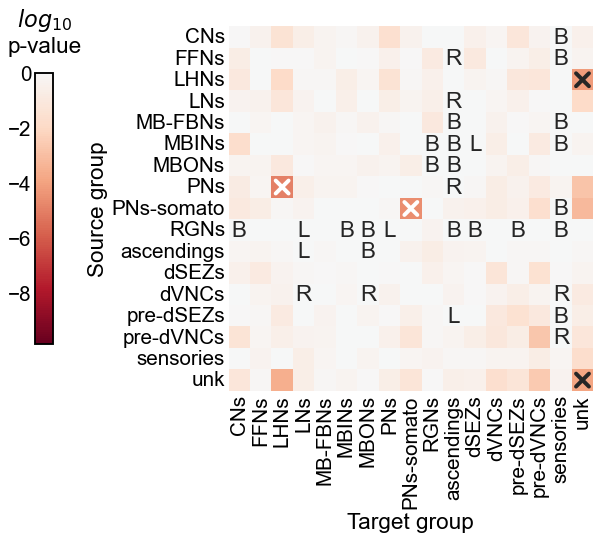

In [4]:

stat, pvalue, misc = stochastic_block_test(
    sub_left_adj,
    sub_right_adj,
    labels1=sub_left_labels,
    labels2=sub_right_labels,
    method="fisher",
    combine_method="tippett",
)
print(pvalue)
glue("sbm_pvalue", pvalue)

set_theme(font_scale=1.25)

fig, ax = plot_pvalues(misc)
gluefig("sbm_pvalues", fig)

## aSBM test

0.4286354067260474


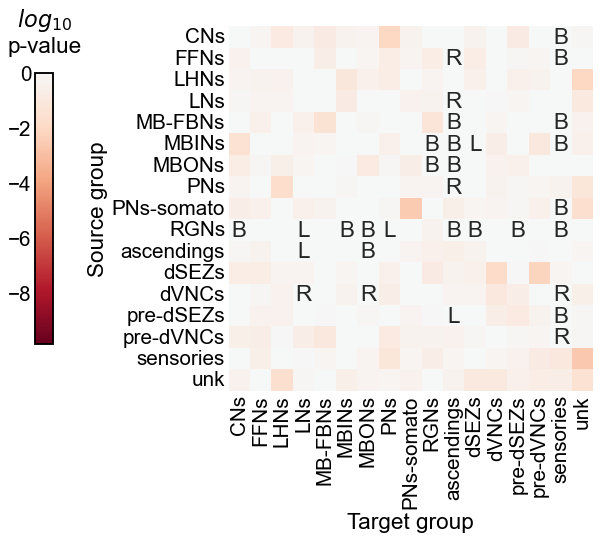

In [5]:

stat, pvalue, misc = stochastic_block_test(
    sub_left_adj,
    sub_right_adj,
    labels1=sub_left_labels,
    labels2=sub_right_labels,
    method="fisher",
    density_adjustment=True,
    combine_method="tippett",
)
print(pvalue)
glue("asbm_pvalue", pvalue)
glue("asbm_pvalue_formatted", f"{pvalue:.2g}")

fig, ax = plot_pvalues(misc)
gluefig("dasbm_pvalues", fig)

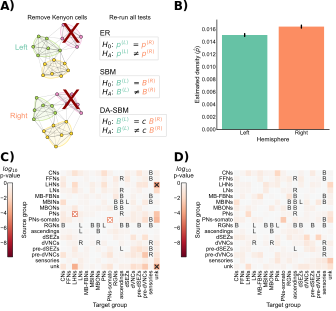

In [6]:

import ast

from pkg.io import FIG_PATH
from svgutils.compose import SVG, Figure, Panel, Text
from pkg.plot import SmartSVG

FIG_PATH = FIG_PATH / FILENAME


# class NotStupidPanel(Panel):
#     @property
#     def height(self):
#         return self.root.getchildren().height
#         # _, height = get_true_width_height(self)
#         # return height

#     @property
#     def width(self):
#         width, _ = get_true_width_height(self)
#         return width

#     def set_width(self, width):
#         current_width = self.width
#         scaler = width / current_width
#         self.scale(scaler)


methods = SmartSVG(FIG_PATH / "kc_minus_methods.svg")
methods.set_width(200)
methods.move(10, 15)
methods_panel = Panel(methods, Text("A)", 0, 10, size=12, weight="bold"))

er = SmartSVG(FIG_PATH / "densities.svg")
er.set_width(170)
er.move(20, 20)
er_panel = Panel(er, Text("B)", 0, 10, size=12, weight="bold"))
er_panel.move(methods.width * 0.87, 0)

sbm = SmartSVG(FIG_PATH / "sbm_pvalues.svg")
sbm.set_width(200)
sbm.move(0, 15)
sbm_panel = Panel(sbm, Text("C)", 0, 10, size=12, weight="bold"))
sbm_panel.move(0, methods.height * 0.9)

asbm = SmartSVG(FIG_PATH / "dasbm_pvalues.svg")
asbm.set_width(200)
asbm.move(0, 15)
asbm_panel = Panel(asbm, Text("D)", 0, 10, size=12, weight="bold"))
asbm_panel.move(methods.width * 0.87, methods.height * 0.9)

# width, _ = get_true_width_height(methods)
# print(width)
# set_width(methods, 200)

# er = SVG(FIG_PATH / "densities.svg")
# set_width(er, 200)
# er.move(), 0)


# text = Text("here", methods.width, 100, size=20)
# text = Text("here", methods.width * 0.8, 100, size=20)

# sbm = SVG(FIG_PATH / 'sbm_pvalues.svg')
# set_width(er, 1000)

# # asbm = SVG(FIG_PATH / 'asbm_pvalues.svg')
# # set_width(er, 1000)


fig = Figure(
    (methods.width + er.width) * 0.91,
    (methods.height + sbm.height) * 0.9,
    methods_panel,
    er_panel,
    sbm_panel,
    asbm_panel,
)
fig.save(FIG_PATH / "kc_minus_composite.svg")
fig